In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/moglix-rto-model-data/model_data.xlsx


In [2]:
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
pd.options.display.max_columns = None
file_name = "/kaggle/input/moglix-rto-model-data/model_data.xlsx"
sheet = "in"
df = pd.read_excel(io=file_name, sheet_name=sheet)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598272 entries, 0 to 598271
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             598272 non-null  int64         
 1   customer_id          598272 non-null  int64         
 2   product_ref          598272 non-null  object        
 3   soih_createdAt       598272 non-null  datetime64[ns]
 4   payment_status       598272 non-null  int64         
 5   item_id              598272 non-null  int64         
 6   is_rto               598272 non-null  int64         
 7   destination_pincode  598272 non-null  int64         
 8   promocode            45855 non-null   object        
 9   order_platform       596356 non-null  object        
 10  is_gstinvoice        598272 non-null  int64         
 11  city                 598268 non-null  object        
 12  state                598272 non-null  object        
 13  mo            

In [4]:
# Data Cleaning
df.fillna(0, inplace=True)
df.head(10)

,order_id,customer_id,product_ref,soih_createdAt,payment_status,item_id,is_rto,destination_pincode,promocode,order_platform,is_gstinvoice,city,state,mo,yr,created_at,source_pincode,item_discount,item_shipping,quantity,brand_name,sources
0,3718347,679769,MSNZ526Y6WNM9X,2022-03-25 11:15:49,6,2216274,0,201309,0,web,1,Gautam Buddha Nagar,Uttar Pradesh,3,2022,2022-03-24 11:38:51,110086.0,0,199000,2,daikin,0
1,3718055,1653298,MSNRKREDXGQ39N,2022-03-25 12:00:14,1,2215889,0,743424,0,web,0,North 24 Parganas,West Bengal,3,2022,2022-03-24 08:16:53,700001.0,0,0,1,gobbler,0
2,3717889,2527071,MSNE9J83MXER9D,2022-03-25 15:03:36,2,2215711,0,110019,0,mobile,0,South Delhi,Delhi,3,2022,2022-03-24 02:21:34,110077.0,0,0,1,cheston,0
3,3718961,2528816,MSN2R297S8XPNR,2022-03-25 15:03:56,2,2217192,0,201306,0,mobile,0,Gautam Buddha Nagar,Uttar Pradesh,3,2022,2022-03-24 17:07:30,110019.0,0,0,1,blackdecker,0
4,3718990,2528884,MSN153VNDQ6YK3,2022-03-25 15:03:59,2,2217223,0,110001,0,web,0,Central Delhi,Delhi,3,2022,2022-03-24 17:32:43,110064.0,0,0,1,zebronics,0
5,3719017,711300,MSN2R9CFNAUWXD,2022-03-25 15:04:02,2,2217258,0,121004,PUMP50,app,0,Faridabad,Haryana,3,2022,2022-03-24 17:50:28,110077.0,50000,29000,1,sameer,0
6,3720746,1863370,MSN2QV262TF1GV,2022-03-25 17:17:30,2,2219471,0,250615,0,web,0,Bagpat,Uttar Pradesh,3,2022,2022-03-25 16:55:27,110052.0,0,39000,1,hillson,0
7,3718193,2251851,MSNZ526P27WW9X,2022-03-25 17:30:59,2,2216052,0,201014,0,app,0,Ghaziabad,Uttar Pradesh,3,2022,2022-03-24 09:52:39,110077.0,0,19000,1,sameer,0
8,3720792,1863370,MSN2QV262TF1GV,2022-03-25 17:41:35,2,2219544,0,250615,0,web,0,Bagpat,Uttar Pradesh,3,2022,2022-03-25 17:27:41,110077.0,0,39000,1,hillson,0
9,3719070,2529040,MSNE5N86E470KL,2022-03-26 10:00:49,2,2217335,0,110063,0,mobile,0,West Delhi,Delhi,3,2022,2022-03-24 18:27:58,201301.0,0,0,1,windek,Facebook


**What percentage of orders is RTO?**

From the numbers below, the percentage of RTO orders is approximatly 29.714%

In [5]:
rto_count = df['is_rto'].value_counts()
print(rto_count)

0    420503
1    177769
Name: is_rto, dtype: int64


**Relation between existing RTO orders and other fields**

Creating a peason correlation heatmap to find relation between is_rto column and other fields.
The correlation is_rto has with other columns in the dataframe is low across and so an accurate conclsion about correlation columns cannot be drawn here.

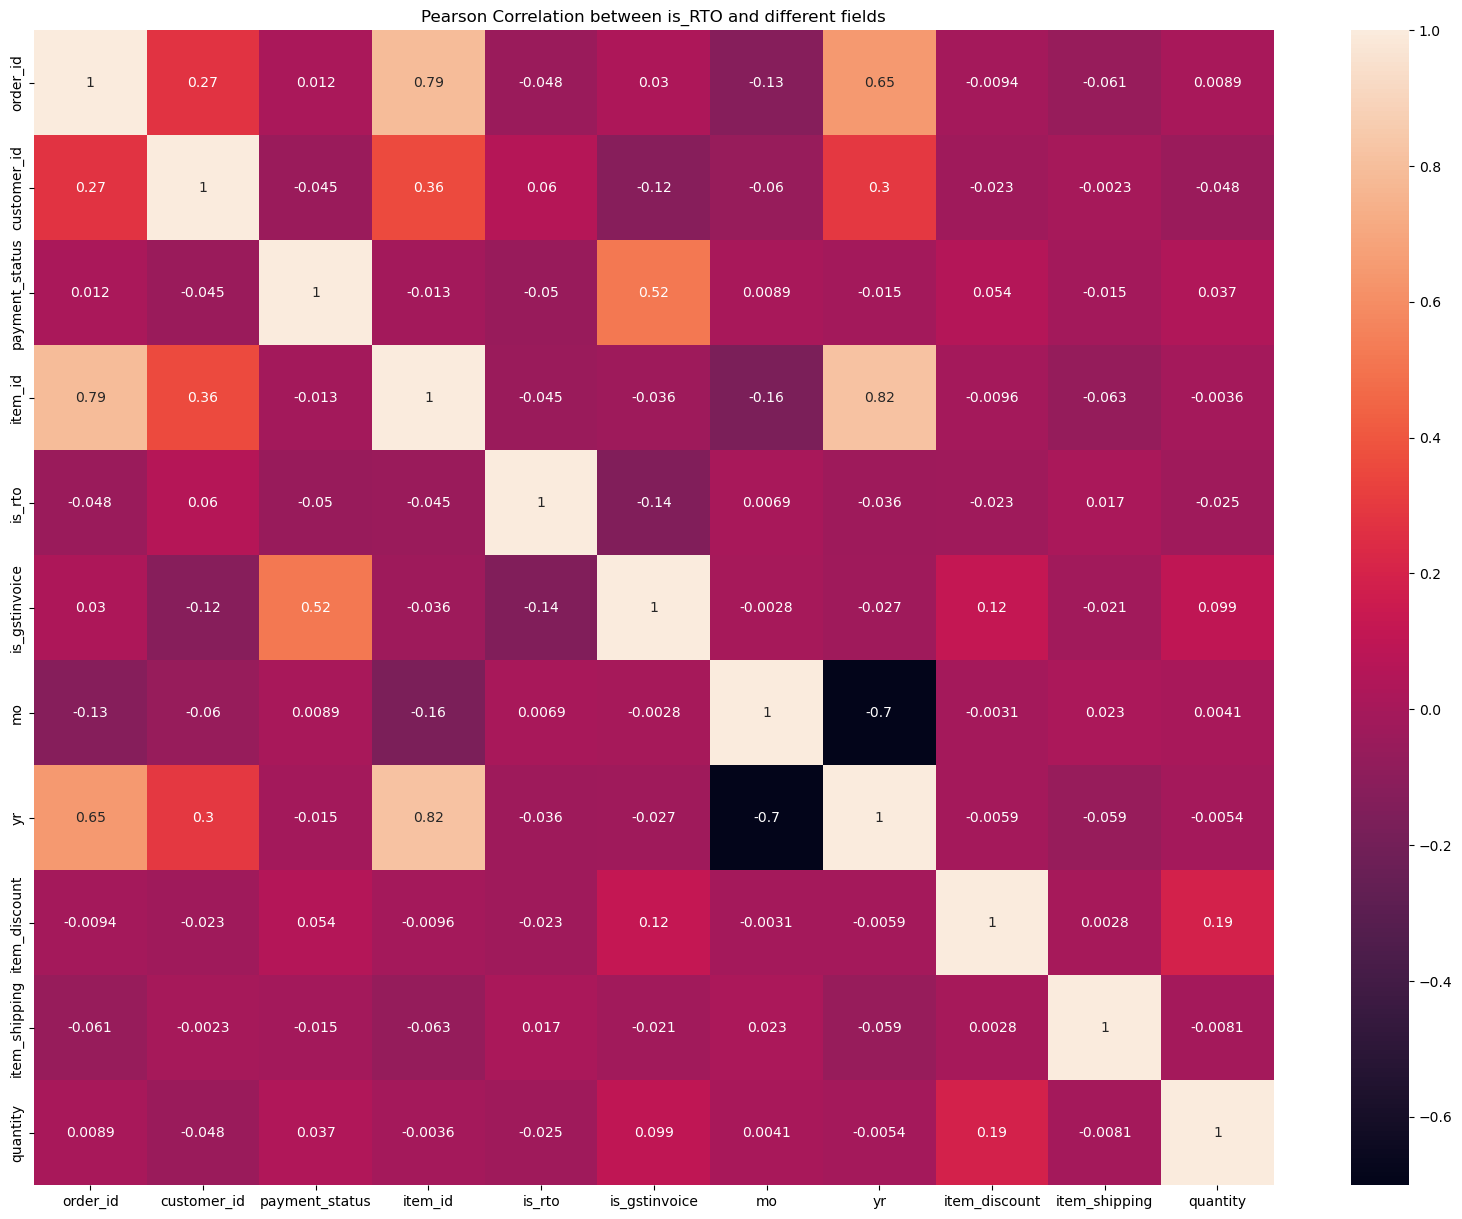

In [6]:
corrDF = df[["order_id", "customer_id", "payment_status", "item_id", 
          "is_rto", "is_gstinvoice", "mo", "yr", "item_discount", "item_shipping", 
             "quantity"]]
# removed source and destination pincodes
correlation = corrDF.corr(method='pearson')
plt.figure(figsize=(20, 15))
plt.title('Pearson Correlation between is_RTO and different fields')
sns.heatmap(correlation, annot=True)
plt.show()

In [7]:
is_RTO = df[df["is_rto"]==1]
is_RTO.head(5)

,order_id,customer_id,product_ref,soih_createdAt,payment_status,item_id,is_rto,destination_pincode,promocode,order_platform,is_gstinvoice,city,state,mo,yr,created_at,source_pincode,item_discount,item_shipping,quantity,brand_name,sources
45,3718979,2528837,MSN2R98LTIP11P,2022-03-27 14:31:18,2,2217212,1,742121,0,app,0,Murshidabad,West Bengal,3,2022,2022-03-24 17:23:29,110077.0,0,19000,1,sameer,0
79,3719497,2355267,MSN2R9CFNAUWXD,2022-03-27 21:01:51,2,2217793,1,210301,0,mobile,0,Hamirpur,Uttar Pradesh,3,2022,2022-03-24 22:28:14,110077.0,0,29000,2,sameer,Facebook
102,3719681,2522712,MSNE5N8VE18YKL,2022-03-28 08:00:24,2,2218042,1,122051,0,app,0,Gurgaon,Haryana,3,2022,2022-03-25 01:12:38,110077.0,0,0,1,cheston,0
103,3718884,2525942,MSNNKQG68WXZ9X,2022-03-28 09:33:31,2,2217091,1,110085,0,mobile,0,North West Delhi,Delhi,3,2022,2022-03-24 16:34:07,110003.0,0,0,1,allencooper,Facebook
104,3719029,660254,MSN2VHJZAAGJO3,2022-03-28 10:03:30,2,2217286,1,223222,0,web,0,Azamgarh,Uttar Pradesh,3,2022,2022-03-24 18:05:43,110017.0,0,0,1,mantra,Facebook


**CUSTOMERS WITH A HIGH RTO NUMBER**

Assuming that a customer with more than 15 RTOs is likely to RTO again, then the following list of customers should be flagged with appopriate titles. The lower limit can be changed as needed. The precentage of RTO orders made by each customer on this list has also been included. The top 50 have been printed.

In [8]:
customer_flag_list = is_RTO.customer_id.value_counts().reset_index(name="count").query("count>15")
print(customer_flag_list.head(5))

     index  count
0  2977024     72
1  3147313     68
2  2682036     46
3  2516664     45
4  2137235     37


In [9]:
list_df = df.customer_id.value_counts().reset_index(name="count")
print(list_df.head(5))

     index  count
0  2491383    447
1  2533902    341
2  2132395    302
3  2362878    288
4   214353    258


In [10]:
total = [0]*customer_flag_list.shape[0]
percent = [0]*customer_flag_list.shape[0]

# Value to check
for i in range(customer_flag_list.shape[0]):
    value = customer_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = list_df["count"].iloc[x].to_string(index=False)
        total[i] = int(total[i])
        percent[i] = (customer_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

customer_flag_list["Total RTO"] = total
customer_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
customer_flag_list = customer_flag_list.sort_values("Percent RTO", ascending=False)

print(customer_flag_list.head(50))

      index  count  Total RTO  Percent RTO
0   2977024     72         72   100.000000
21  3025913     26         26   100.000000
29  2224998     24         24   100.000000
30  2804160     24         24   100.000000
33  3020213     23         23   100.000000
1   3147313     68         68   100.000000
39  3088345     21         21   100.000000
42  3125676     19         19   100.000000
43  2774082     19         19   100.000000
47  2370678     19         19   100.000000
52  2730257     18         18   100.000000
54  2733455     18         18   100.000000
55  3182239     17         17   100.000000
60  2860060     17         17   100.000000
62  3076175     17         17   100.000000
65  1345019     17         17   100.000000
71  2499943     16         16   100.000000
23  3025491     25         25   100.000000
38   327158     21         21   100.000000
9   2869527     31         31   100.000000
15  2556613     28         28   100.000000
6   2325729     34         34   100.000000
11  1406573

**CORRELATION BETWEEN PAYMENT STATUS AND RTO true VALUE**

From the below numbers, an early stage of payment is more likely to be RTO. Approximately 98.74% of RTO were in the payment stage 2. Approximately 34% of orders in the payment stage 2 are RTO.

In [11]:
paystats_flag_list = is_RTO.payment_status.value_counts().reset_index(name="count")
print(paystats_flag_list)

   index   count
0      2  175532
1      1    1492
2      6     494
3      4     146
4      3      96
5      5       9


In [12]:
list_df = df.payment_status.value_counts().reset_index(name="count")
print(list_df)

   index   count
0      2  510341
1      1   56967
2      6   19792
3      4    6829
4      3    3997
5      5     346


In [13]:
total = [0]*paystats_flag_list.shape[0]
percent = [0]*paystats_flag_list.shape[0]

# Value to check
for i in range(paystats_flag_list.shape[0]):
    value = paystats_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (paystats_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

paystats_flag_list["Total RTO"] = total
paystats_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
paystats_flag_list = paystats_flag_list.sort_values("Percent RTO", ascending=False)

print(paystats_flag_list)

   index   count  Total RTO  Percent RTO
0      2  175532     510341    34.395042
1      1    1492      56967     2.619060
5      5       9        346     2.601156
2      6     494      19792     2.495958
4      3      96       3997     2.401801
3      4     146       6829     2.137941


**CORRELATION BETWEEN DESTINATION PINCODE AND RTO true VALUE**

Certain destinations might point towards a scam or possible RTO. These pincodes can be listed separately and loked into a little more. I have printed the destination pincodes which are associated with a high percent RTO here (the lower limit I used is 15, can be changed). 

In [14]:
dest_flag_list = is_RTO.destination_pincode.value_counts().reset_index(name="count").query("count>15")
print(dest_flag_list.head(5))

    index  count
0  795001    341
1  201301    298
2  191111    283
3  192101    271
4  190001    270


In [15]:
list_df = df.destination_pincode.value_counts().reset_index(name="count")
print(list_df.head(5))

    index  count
0  795001   1656
1  201301   1478
2  796001   1409
3  795128   1073
4  797112   1037


In [16]:
total = [0]*dest_flag_list.shape[0]
percent = [0]*dest_flag_list.shape[0]

# Value to check
for i in range(dest_flag_list.shape[0]):
    value = dest_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (dest_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

dest_flag_list["Total RTO"] = total
dest_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
dest_flag_list = dest_flag_list.sort_values("Percent RTO", ascending=False)

print(dest_flag_list.head(5))

       index  count  Total RTO  Percent RTO
2694  802223     17         17   100.000000
1109  721170     31         32    96.875000
598   343024     43         45    95.555556
50    483113    129        135    95.555556
44    473781    134        141    95.035461


**CORRELATION BETWEEN SOURCE PINCODE AND RTO true VALUE**

Like destinations, certain source pincodes might also indicate a possible RTO. These pincodes can be listed separately and looked into a little more. I have printed the source pincodes associated with a high percent RTO here (the lower limit I used is 15, can be changed).

In [17]:
source_flag_list = is_RTO.source_pincode.value_counts().reset_index(name="count").query("count>15")
print(source_flag_list.head(5))

      index  count
0  110077.0  25163
1  110039.0  11398
2  110006.0   6939
3  110025.0   6593
4  110059.0   5724


In [18]:
list_df = df.source_pincode.value_counts().reset_index(name="count")
print(list_df.head(5))

      index  count
0  110077.0  77433
1  110039.0  33244
2  110006.0  20007
3  110059.0  19312
4  282001.0  18606


In [19]:
total = [0]*source_flag_list.shape[0]
percent = [0]*source_flag_list.shape[0]

# Value to check
for i in range(source_flag_list.shape[0]):
    value = source_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (source_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

source_flag_list["Total RTO"] = total
source_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
source_flag_list = source_flag_list.sort_values("Percent RTO", ascending=False)

print(source_flag_list.head(5))

        index  count  Total RTO  Percent RTO
211  122052.0     78        107    72.897196
291  122009.0     36         51    70.588235
286  501401.0     37         60    61.666667
316  394601.0     28         48    58.333333
262  500001.0     48         83    57.831325


**CORRELATION BETWEEN DISCOUNT AMOUNTS AND RTO true VALUE**

The list printed below shows the top 5 discount amounts which had an RTO. Approximately 97.08% of the RTO orders were for products which had no discount on them. However looking at the percent RTO for different discounts, drawing a conclusion might be a little difficult.

In [20]:
disc_flag_list = is_RTO.item_discount.value_counts().reset_index(name="count").query("count>15")
print(disc_flag_list.head(5))

    index   count
0       0  172574
1   50000    1660
2  100000     735
3  200000     200
4   75000      69


In [21]:
list_df = df.item_discount.value_counts().reset_index(name="count")
print(list_df.head(5))

    index   count
0       0  552451
1   50000    9415
2  100000    4341
3  200000    1192
4  400000     614


In [22]:
total = [0]*disc_flag_list.shape[0]
percent = [0]*disc_flag_list.shape[0]

# Value to check
for i in range(disc_flag_list.shape[0]):
    value = disc_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (disc_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

disc_flag_list["Total RTO"] = total
disc_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
disc_flag_list = disc_flag_list.sort_values("Percent RTO", ascending=False)

print(disc_flag_list.head(5))

      index  count  Total RTO  Percent RTO
15  1017000     18         19    94.736842
16   466000     17         18    94.444444
9   1016000     23         25    92.000000
10  1235000     21         31    67.741935
20     6000     16         29    55.172414


**CORRELATION BETWEEN STATE AND RTO true VALUE**

The lists printed below shows the top 5 states which had RTO orders. Approximately 9.77% of the RTO orders were from Uttar Pradesh.

In [23]:
state_flag_list = is_RTO.state.value_counts().reset_index(name="count").query("count>15")
print(state_flag_list.head(5))

           index  count
0  Uttar Pradesh  17362
1    Maharashtra  13226
2      Karnataka  12969
3          Bihar  12454
4          Assam  11021


In [24]:
list_df = df.state.value_counts().reset_index(name="count")
print(list_df.head(5))

           index  count
0  Uttar Pradesh  55251
1    Maharashtra  51104
2      Karnataka  46875
3     Tamil Nadu  42846
4    West Bengal  31423


In [25]:
total = [0]*state_flag_list.shape[0]
percent = [0]*state_flag_list.shape[0]

# Value to check
for i in range(state_flag_list.shape[0]):
    value = state_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (state_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

state_flag_list["Total RTO"] = total
state_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
state_flag_list = state_flag_list.sort_values("Percent RTO", ascending=False)

print(state_flag_list.head(5))

                          index  count  Total RTO  Percent RTO
9             Jammu and Kashmir   8643      18959    45.587847
3                         Bihar  12454      29451    42.287189
5                     Rajasthan  10705      26675    40.131209
18                      Tripura   3271       8200    39.890244
34  Andaman and Nicobar Islands     22         57    38.596491


**CORRELATION BETWEEN ITEM SHIPPING AND RTO true VALUE**

The lists printed below shows the top 5 item shipping rates which had RTO orders. Approximately 68.61% of the RTO orders were those which had no shipping cost.

In [26]:
shipping_flag_list = is_RTO.item_shipping.value_counts().reset_index(name="count").query("count>15")
print(shipping_flag_list.head(5))

   index   count
0      0  121970
1  49000   15898
2  19000   12214
3  29000    8863
4  99000    5106


In [27]:
list_df = df.item_shipping.value_counts().reset_index(name="count")
print(list_df.head(5))

   index   count
0      0  406447
1  19000   51751
2  49000   47038
3  29000   26084
4  69000   16500


In [28]:
total = [0]*shipping_flag_list.shape[0]
percent = [0]*shipping_flag_list.shape[0]

# Value to check
for i in range(shipping_flag_list.shape[0]):
    value = shipping_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (shipping_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

shipping_flag_list["Total RTO"] = total
shipping_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
shipping_flag_list = shipping_flag_list.sort_values("Percent RTO", ascending=False)
print(shipping_flag_list.head(5))

     index  count  Total RTO  Percent RTO
13  249000    321        635    50.551181
11  129000    460       1110    41.441441
10  179000    625       1568    39.859694
9   139000    718       1857    38.664513
12  149000    364        979    37.180797


**CORRELATION BETWEEN QUANTITY AND RTO true VALUE**

The list printed below shows some correlation between RTO and quantity. Aproximately 91.92% of total RTO orders were those with single quantity of items. So we could assume that smaller quantity orders have a higher likelihood of RTO.

In [29]:
quant_flag_list = is_RTO.quantity.value_counts().reset_index(name="count").query("count>15")
print(quant_flag_list.head(5))

   index   count
0      1  163416
1      2    8565
2      3    1922
3      4    1431
4      5     926


In [30]:
list_df = df.quantity.value_counts().reset_index(name="count")
print(list_df.head(5))

   index   count
0      1  536697
1      2   34033
2      3    7690
3      4    5961
4      5    4371


In [31]:
total = [0]*quant_flag_list.shape[0]
percent = [0]*quant_flag_list.shape[0]

# Value to check
for i in range(quant_flag_list.shape[0]):
    value = quant_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (quant_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

quant_flag_list["Total RTO"] = total
quant_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
quant_flag_list = quant_flag_list.sort_values("Percent RTO", ascending=False)
print(quant_flag_list.head(5))

    index   count  Total RTO  Percent RTO
0       1  163416     536697    30.448465
1       2    8565      34033    25.166750
2       3    1922       7690    24.993498
3       4    1431       5961    24.006039
15     14      21         91    23.076923


**CORRELATION BETWEEN ORDER PLATFORM AND RTO true VALUE**

The list printed below shows correlation between RTO and order platform. Approximately 4.93% of total RTO orders were made on mobile. So we could assume that mobile orders have a higher likelihood of RTO.

In [32]:
platform_flag_list = is_RTO.order_platform.value_counts().reset_index(name="count")
print(platform_flag_list)

    index   count
0  mobile  133205
1     app   38197
2     web    6150
3       0     178
4     oms      39


In [33]:
list_df = df.order_platform.value_counts().reset_index(name="count")
print(list_df.head(5))

    index   count
0  mobile  385930
1     app  142252
2     web   67329
3       0    1916
4     oms     845


In [34]:
total = [0]*platform_flag_list.shape[0]
percent = [0]*platform_flag_list.shape[0]

# Value to check
for i in range(platform_flag_list.shape[0]):
    value = platform_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (platform_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

platform_flag_list["Total RTO"] = total
platform_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
platform_flag_list = platform_flag_list.sort_values("Percent RTO", ascending=False)
print(platform_flag_list)

    index   count  Total RTO  Percent RTO
0  mobile  133205     385930    34.515327
1     app   38197     142252    26.851644
3       0     178       1916     9.290188
2     web    6150      67329     9.134251
4     oms      39        845     4.615385


**CORRELATION BETWEEN SOURCES AND RTO true VALUE**

The list printed below shows correlation between RTO and source. From the numbers we can see that approximately 44% of the orders placed on Facebook are RTO.

In [35]:
sources_flag_list = is_RTO.sources.value_counts().reset_index(name="count")
print(source_flag_list)

        index  count  Total RTO  Percent RTO
211  122052.0     78        107    72.897196
291  122009.0     36         51    70.588235
286  501401.0     37         60    61.666667
316  394601.0     28         48    58.333333
262  500001.0     48         83    57.831325
..        ...    ...        ...          ...
350  414003.0     18        225     8.000000
345  560043.0     19        264     7.196970
276  834001.0     40        948     4.219409
358  560027.0     17        537     3.165736
295  400093.0     35       1427     2.452698

[368 rows x 4 columns]


In [36]:
list_df = df.sources.value_counts().reset_index(name="count")
print(list_df.head(5))

      index   count
0         0  476454
1  Facebook  121818


In [37]:
total = [0]*sources_flag_list.shape[0]
percent = [0]*sources_flag_list.shape[0]

# Value to check
for i in range(sources_flag_list.shape[0]):
    value = sources_flag_list["index"].iloc[i]
    mask = list_df["index"].isin([value])
    if any(mask):
        x = list_df.index[mask].tolist()
        total[i] = int(list_df["count"].iloc[x].to_string(index=False))
        percent[i] = (sources_flag_list["count"].iloc[i]/total[i]) * 100
    else:
        total[i] = -1
        percent[i] = -1

sources_flag_list["Total RTO"] = total
sources_flag_list["Percent RTO"] = percent

# sorting in descending order of percent RTO column
sources_flag_list = sources_flag_list.sort_values("Percent RTO", ascending=False)
print(sources_flag_list)

      index   count  Total RTO  Percent RTO
1  Facebook   54203     121818    44.495066
0         0  123566     476454    25.934508
